# Power Spectrum Inference

This notebook demonstrates **power-spectrum-level** Bayesian inference of cosmological
parameters from convergence maps using the Knox-formula likelihood.

Compared to the full-field approach (notebook 11), this is computationally cheaper
because the data compression step (maps → C_ell) is done once up-front:

1. Load observed convergence maps from a Parquet catalog
2. Compress to all auto- (and optionally cross-) angular power spectra
3. Build the NumPyro power-spectrum model with the Knox-formula likelihood
4. Sample the posterior with MCMC (`batched_sampling`)

## Setup

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.97"
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # switch to 'cpu' if no GPU available

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import numpy as np
from numpyro.handlers import condition, seed, trace

import fwd_model_tools as ffi

print(f"Number of devices: {jax.device_count()}")
print(f"Devices: {jax.devices()}")
jax.config.update("jax_enable_x64", False)

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2026-02-26 01:56:41,184:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/j

Number of devices: 1
Devices: [CpuDevice(id=0)]


## Load Catalog

Set `CATALOG_PATH` to a Parquet file produced by a previous simulation run.
The catalog contains convergence maps for each redshift bin as a batched
`SphericalDensity` (or `FlatDensity`) field.

In [2]:
CATALOG_PATH = "output/fields/fields_0.parquet"  # <- update to your path

catalog = ffi.io.Catalog.from_parquet(CATALOG_PATH)
print(f"Catalog entries: {len(catalog)}")

# The catalog field is a batched SphericalDensity with shape (n_bins, npix)
kappa_field = catalog.field[0]
print(f"Kappa field type:  {type(kappa_field).__name__}")
print(f"Kappa field shape: {kappa_field.array.shape}")

/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/io/catalog.py:289: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  val = jnp.asarray(item[key], dtype=jnp.float64)


Catalog entries: 1
Kappa field type:  SphericalDensity
Kappa field shape: (10, 12582912)


## Compute Observed C_ell

`cross_angular_cl()` computes all K = B*(B+1)/2 auto- and cross-spectra for a
batched field with B bins in a single healpy call.  The returned `PowerSpectrum`
stores the ell-array in `.wavenumber` and all spectra in `.array` with shape
`(K, n_ell)`, ordered `(0,0), (0,1), …, (B-1,B-1)`.

In [14]:
# For spherical maps use lmax; for flat maps use ell_edges instead
LMAX = 512

ps = kappa_field[:4].cross_angular_cl(lmax=LMAX)

print(f"wavenumber shape: {ps.wavenumber.shape}")
print(f"spectra shape:    {ps.array.shape}")
print(f"ell range: [{ps.wavenumber[0]:.0f}, {ps.wavenumber[-1]:.0f}]")

wavenumber shape: (513,)
spectra shape:    (10, 513)
ell range: [0, 512]


## Build Configuration

We pass `ells=ps.wavenumber` so the theory model evaluates at exactly the
same multipoles as the observed spectra. `f_sky` corrects the Knox formula
for partial sky coverage; set it to the observed sky fraction.

In [4]:
nz_sources = ffi.io.get_stage3_nz_shear()

priors = {
    "Omega_c": ffi.infer.dist.PreconditionnedUniform(0.1, 0.5),
    "sigma8": ffi.infer.dist.PreconditionnedUniform(0.6, 1.0),
}

config = ffi.ppl.Configurations(
    mesh_size=(64, 64, 64),        # not used by power-spec model but required by dataclass
    box_size=(500.0, 500.0, 500.0),
    nside=kappa_field.nside,
    nz_shear=nz_sources,
    fiducial_cosmology=jc.Planck18,
    sigma_e=0.26,
    priors=priors,
    geometry="spherical",
    ells=ps.wavenumber,
    use_cross=True,   # set True to include cross-spectra in the likelihood
    f_sky=1.0,         # update to the actual observed sky fraction
)

print(f"nside:     {config.nside}")
print(f"use_cross: {config.use_cross}")
print(f"f_sky:     {config.f_sky}")
print(f"n_ells:    {len(config.ells)}")

nside:     1024
use_cross: True
f_sky:     1.0
n_ells:    513


## Build Observed Dictionary

The observed spectra must be keyed exactly as the model's sample sites:
`C_ell_auto_{i}` for auto-spectra and `C_ell_cross_{i}_{j}` for cross-spectra.
We reconstruct the same `pair_order` used internally by `powerspec_probmodel`.

In [5]:
from itertools import combinations_with_replacement

nb_bins = len(config.nz_shear)
pair_order = sorted(combinations_with_replacement(range(nb_bins), 2))

obs = {}
for idx, (i, j) in enumerate(pair_order):
    if i == j:
        obs[f"C_ell_auto_{i}"] = jnp.array(ps.array[idx])
    elif config.use_cross:
        obs[f"C_ell_cross_{i}_{j}"] = jnp.array(ps.array[idx])

print("Observed sites:")
for k, v in obs.items():
    print(f"  {k}: shape={v.shape}")

Observed sites:
  C_ell_auto_0: shape=(513,)
  C_ell_cross_0_1: shape=(513,)
  C_ell_cross_0_2: shape=(513,)
  C_ell_cross_0_3: shape=(513,)
  C_ell_auto_1: shape=(513,)
  C_ell_cross_1_2: shape=(513,)
  C_ell_cross_1_3: shape=(513,)
  C_ell_auto_2: shape=(513,)
  C_ell_cross_2_3: shape=(513,)
  C_ell_auto_3: shape=(513,)


## Build and Inspect the Probabilistic Model

`powerspec_probmodel` returns a zero-argument NumPyro model. We can inspect
the trace before conditioning to verify all expected sites are present.

In [8]:
model = ffi.ppl.powerspec_probmodel(config)

# Dry-run: sample once from the prior to check the trace
model_trace = trace(seed(model, 0)).get_trace()

print("Sample sites in model:")
for name, site in model_trace.items():
    if site["type"] == "sample":
        print(f"  {name}: shape={site['value'].shape}")

Sample sites in model:
  Omega_c: shape=()
  sigma8: shape=()
  C_ell_auto_0: shape=(513,)
  C_ell_cross_0_1: shape=(513,)
  C_ell_cross_0_2: shape=(513,)
  C_ell_cross_0_3: shape=(513,)
  C_ell_auto_1: shape=(513,)
  C_ell_cross_1_2: shape=(513,)
  C_ell_cross_1_3: shape=(513,)
  C_ell_auto_2: shape=(513,)
  C_ell_cross_2_3: shape=(513,)
  C_ell_auto_3: shape=(513,)


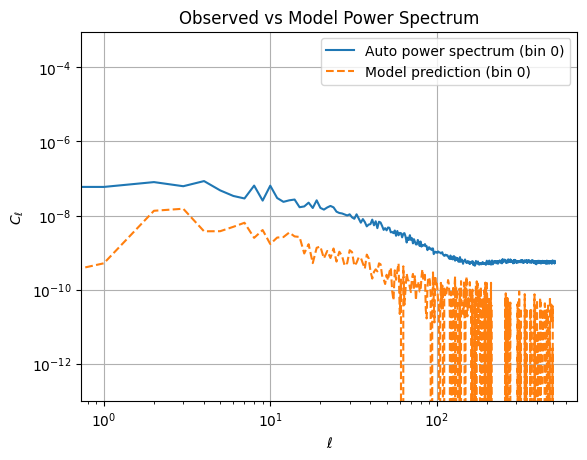

In [15]:
import matplotlib.pyplot as plt
plt.loglog(ps.wavenumber, ps.array[0], label="Auto power spectrum (bin 0)")
cl_auto_0 = model_trace['C_ell_auto_0']['value']
plt.loglog(ps.wavenumber, cl_auto_0, label="Model prediction (bin 0)", linestyle='--')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Observed vs Model Power Spectrum")
plt.legend()
plt.grid()
plt.show()

## Condition on Observed Data

`numpyro.handlers.condition` replaces the `C_ell_*` sample sites with the
observed spectra, turning the joint model into a likelihood for the
cosmological parameters.

In [10]:
conditioned = condition(model, data=obs)

# Starting point for HMC: fiducial cosmology values
fiducial = jc.Planck18()
init_params = {
    "Omega_c": jnp.array(fiducial.Omega_c),
    "sigma8": jnp.array(fiducial.sigma8),
}

print("Init params:")
for k, v in init_params.items():
    print(f"  {k}: {float(v):.4f}")

Init params:
  Omega_c: 0.2607
  sigma8: 0.8102


## Define Save Callback

For power-spectrum inference the samples are small (just cosmological parameters),
so we save them as a simple `.npz` file instead of a Parquet catalog.

In [16]:
def save_npz(samples: dict, path: str, batch_id: int) -> None:
    """Save cosmological parameter samples to a compressed npz file."""
    os.makedirs(path, exist_ok=True)
    np.savez(
        os.path.join(path, f"samples_{batch_id}.npz"),
        **{k: np.asarray(v) for k, v in samples.items()},
    )
    print(f"  Saved batch {batch_id} to {path}/samples_{batch_id}.npz")

## Run MCMC Sampling

`batched_sampling` runs NUTS in sequential batches, checkpointing state after
each batch so a long run can be interrupted and resumed.

For production use, increase `num_warmup`, `num_samples`, and `batch_count`.

In [17]:
OUTPUT_PATH = "output/ps_inference"
sample_key = jax.random.PRNGKey(42)

ffi.infer.batched_sampling(
    conditioned,
    #init_params=init_params,
    path=OUTPUT_PATH,
    rng_key=sample_key,
    num_warmup=200,
    num_samples=100,
    batch_count=3,
    sampler="NUTS",
    backend="blackjax",
    progress_bar=True,
    save_callback=save_npz,
)

ValueError: Normal distribution got invalid loc parameter.

## Load and Inspect Results

In [ ]:
import glob

npz_files = sorted(glob.glob(f"{OUTPUT_PATH}/samples_*.npz"))
print(f"Found {len(npz_files)} batch file(s): {npz_files}")

all_samples = {}
for f in npz_files:
    data = np.load(f)
    for k in data.files:
        all_samples.setdefault(k, []).append(data[k])

# Concatenate batches along the sample axis
all_samples = {k: np.concatenate(v, axis=0) for k, v in all_samples.items()}

print("\nParameter shapes and posterior means:")
for k, v in all_samples.items():
    if v.ndim >= 1 and np.issubdtype(v.dtype, np.floating):
        print(f"  {k}: shape={v.shape}  mean={v.mean():.4f}  std={v.std():.4f}")